In [1]:
# Goals: to find 800 repository and get ML to classify its language

# ACQUIRE

In [2]:
# import
import requests
import json
from bs4 import BeautifulSoup

In [3]:
# set up API request headers
from env import github_token, github_username

headers = {
    "Authorization": f"token {github_token}",
    "User-Agent": github_username
}

In [4]:
# make API requests to get repository names
language = "python"
api_url = f"https://api.github.com/search/repositories?q=language:{language}&sort=stars&order=desc&per_page=100"
response = requests.get(api_url, headers=headers)

if response.status_code == 200:
    repositories = response.json()["items"]
else:
    print(f"Failed to fetch repository list. Status code: {response.status_code}")
    exit()

Goal: add all these results to a list, then find a way to go through and request another 10 results with always adding them to a list. clean up emphasis text from entries

In [5]:
import requests
import json
from env import github_token, github_username

# Define the headers with your token and username
headers = {
    "Authorization": f"token {github_token}",
    "User-Agent": github_username
}

# Define a function to get repositories based on a query and page
def get_repositories(query, sort="stars", order="desc", page=1):
    base_url = "https://api.github.com/search/repositories"
    params = {
        "q": query,
        "sort": sort,
        "order": order,
        "per_page": 10,  # You can get up to 100 results per page.
        "page": page  # Specify the page number
    }
    response = requests.get(base_url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Search for breast cancer related repositories and handle pagination
query = "breast cancer"
page = 1

# Create a list to collect the repository data
repository_data = []

while page <= 10:
    response_json = get_repositories(query, page=page)
    if response_json is None:
        print(f"Failed to fetch page {page} of repositories.")
        break

    # Extract and collect repository names
    for repo in response_json["items"]:
        repository_data.append({
            "full_name": repo["full_name"]
        })

    # Check if there are more pages
    if "Link" in response.headers:
        next_link = response.headers["Link"]
        if 'rel="next"' not in next_link:
            break
    else:
        break
    page += 1


In [6]:
# ... (Previous code remains the same)

# Extract only the repository names from the dictionaries
repository_names = [repo_data["full_name"] for repo_data in repository_data]

# Save the repository names list to a JSON file
with open("breast_cancer_repository.json", "w") as json_file:
    json.dump(repository_names, json_file, indent=2)

print("Data saved to breast_cancer_repository.json")


Data saved to breast_cancer_repository.json


In [7]:
import pandas as pd
df = pd.read_json('github_data.json')
df.shape

(95, 3)

# Prep phase

In [8]:
import unicodedata
import re
import json


import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords





In [9]:
import wrangle as w

In [10]:
df['clean_norm_token'] = df.readme_contents.apply(w.tokenize).apply(w.basic_clean).apply(w.remove_stopwords).apply(w.lemmatize)

# tokenizes, cleans, remove stopwprds, lemmatize the text in the readme_contents and 
# stores the processed text in a new column clean_norm_token

df.clean_norm_token = df.clean_norm_token.str.replace('124', '')
df
# it removes any occurences of the string '124' from the clean_norm_token column

,repo,language,readme_contents,clean_norm_token
0,/nyukat/breast_cancer_classifier,Jupyter Notebook,# Deep Neural Networks Improve Radiologists' P...,deep neural network improve radiologist ' perf...
1,/lishen/end2end-all-conv,Jupyter Notebook,Shield: [![CC BY-NC-SA 4.0][cc-by-nc-sa-shield...,shield cc byncsa 40 ccbyncsashield ccbyncsa wo...
2,/ImagingLab/ICIAR2018,Python,# ICIAR2018\n### Two-Stage Convolutional Neura...,iciar2018 twostage convolutional neural networ...
3,/Jean-njoroge/Breast-cancer-risk-prediction,Jupyter Notebook,# Breast-cancer-risk-prediction\n\n> Necessity...,breastcancerriskprediction necessity mother in...
4,/abhinavsagar/breast-cancer-classification,Jupyter Notebook,# Breast-cancer-classification\n\nBreast Cance...,breastcancerclassification classification usin...
...,...,...,...,...
90,/BishalDali/Breast_Cancer_Prediction,Jupyter Notebook,# Breast_Cancer_Prediction,breastcancerprediction
91,/IndianAIProduction-Channel/Breast-Cancer-Dete...,HTML,# Breast-Cancer-Detection-App\n Breast Cancer ...,breastcancerdetectionapp detection app using m...
92,/gmineo/Breast-Cancer-Prediction-Project,R,# Breast-Cancer-Prediction\n\nChoose-your-own ...,breastcancerprediction chooseyourown project h...
93,/iharnoor/BreastCancer-Kmeans,Python,# BreastCancer-Kmeans\nClustering the data int...,breastcancerkmeans clustering data using kmean...


In [11]:
df.language.value_counts()

Python              45
Jupyter Notebook    29
R                    4
HTML                 4
MATLAB               3
TeX                  2
C#                   2
Matlab               2
Objective-C          1
Dart                 1
Name: language, dtype: int64

In [12]:
# List of languages to combine into "Other"
languages_to_combine = ['Jupyter Notebook', 'MATLAB', 'TeX', 'C#', 'Matlab', 'Objective-C', 'Dart']

# Replace the specified languages with "Other"
df['language'] = df['language'].replace(languages_to_combine, 'other')
df

,repo,language,readme_contents,clean_norm_token
0,/nyukat/breast_cancer_classifier,other,# Deep Neural Networks Improve Radiologists' P...,deep neural network improve radiologist ' perf...
1,/lishen/end2end-all-conv,other,Shield: [![CC BY-NC-SA 4.0][cc-by-nc-sa-shield...,shield cc byncsa 40 ccbyncsashield ccbyncsa wo...
2,/ImagingLab/ICIAR2018,Python,# ICIAR2018\n### Two-Stage Convolutional Neura...,iciar2018 twostage convolutional neural networ...
3,/Jean-njoroge/Breast-cancer-risk-prediction,other,# Breast-cancer-risk-prediction\n\n> Necessity...,breastcancerriskprediction necessity mother in...
4,/abhinavsagar/breast-cancer-classification,other,# Breast-cancer-classification\n\nBreast Cance...,breastcancerclassification classification usin...
...,...,...,...,...
90,/BishalDali/Breast_Cancer_Prediction,other,# Breast_Cancer_Prediction,breastcancerprediction
91,/IndianAIProduction-Channel/Breast-Cancer-Dete...,HTML,# Breast-Cancer-Detection-App\n Breast Cancer ...,breastcancerdetectionapp detection app using m...
92,/gmineo/Breast-Cancer-Prediction-Project,R,# Breast-Cancer-Prediction\n\nChoose-your-own ...,breastcancerprediction chooseyourown project h...
93,/iharnoor/BreastCancer-Kmeans,Python,# BreastCancer-Kmeans\nClustering the data int...,breastcancerkmeans clustering data using kmean...


In [13]:
df.language.value_counts().head(4)

Python    45
other     40
R          4
HTML       4
Name: language, dtype: int64

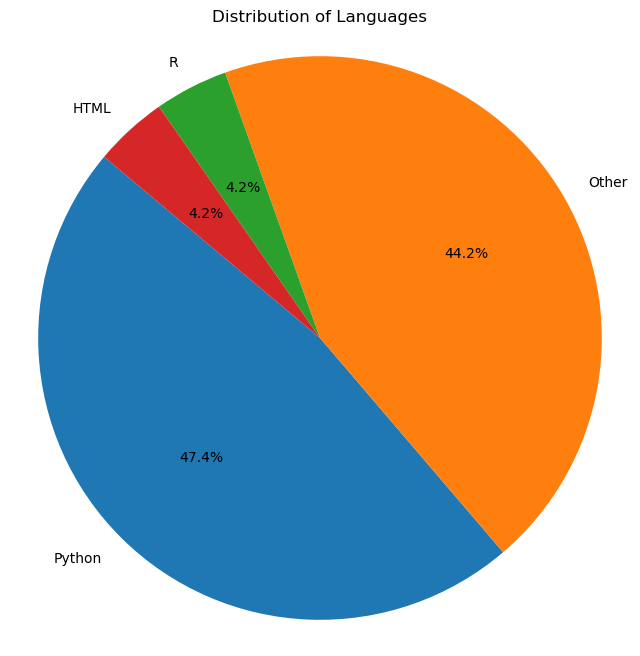

In [14]:
import matplotlib.pyplot as plt

# Your data
labels = ['Python', 'Other', 'R', 'HTML']
sizes = [45, 42, 4, 4]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Add a title
plt.title('Distribution of Languages')

# Display the pie chart
plt.show()


# Exploration

In [ ]:
import re
import unicodedata
import pandas as pd
import nltk

In [18]:
word_counts = {}  # Define word_counts as an empty dictionary

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]
    
    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()
    
    # Count the words and store the count in the dictionary
    word_counts[language] = len(words)

# Create a DataFrame from the word counts dictionary
word_counts_df = pd.DataFrame(word_counts.items(), columns=['language', 'word_count'])

# Display the word counts
print(word_counts_df)



  language  word_count
0    other       14764
1   Python       14439
2        R         959
3     HTML         487


In [19]:
python_words = w.clean(' '.join(train[train.language=='Python']['clean_norm_token']))
html_words = w.clean(' '.join(train[train.language=='HTML']['clean_norm_token']))
r_words = w.clean(' '.join(train[train.language=='R']['clean_norm_token']))
other_words = w.clean(' '.join(train[train.language=='other']['clean_norm_token']))

all_words = w.clean(' '.join(df['clean_norm_token']))
#various programming languages and aggregating the words associated with each language

In [20]:
# Calculate word frequencies
python_freq = pd.Series(python_words).value_counts()
html_freq = pd.Series(html_words).value_counts()
r_freq = pd.Series(r_words).value_counts()
other_freq = pd.Series(other_words).value_counts()

In [21]:
from collections import Counter


In [22]:
b

                Python  HTML   R  Other
9                  675     0  19      2
image              148     0   0    116
training            77     0   0     19
model               76     0   0     74
dataset             74     0   0     39
run                 72     0   9     29
using               72     2   7     46
1                   71     0   4     37
data                70     0  25     61
epoch               62     0   0      3
python              59     0   0     26
learning            57     2   0     43
use                 51     0   1     42
accuracy            50     0   0     11
finished            50     0   0      1
test                44     0   2     12
folder              44     0   0     13
2                   41     0   6     30
file                40     0   8     38
code                40     0   9     58
train               39     0   0     13
used                37     0   5     48
classification      37     0   0     15
feature             37     0   0      9


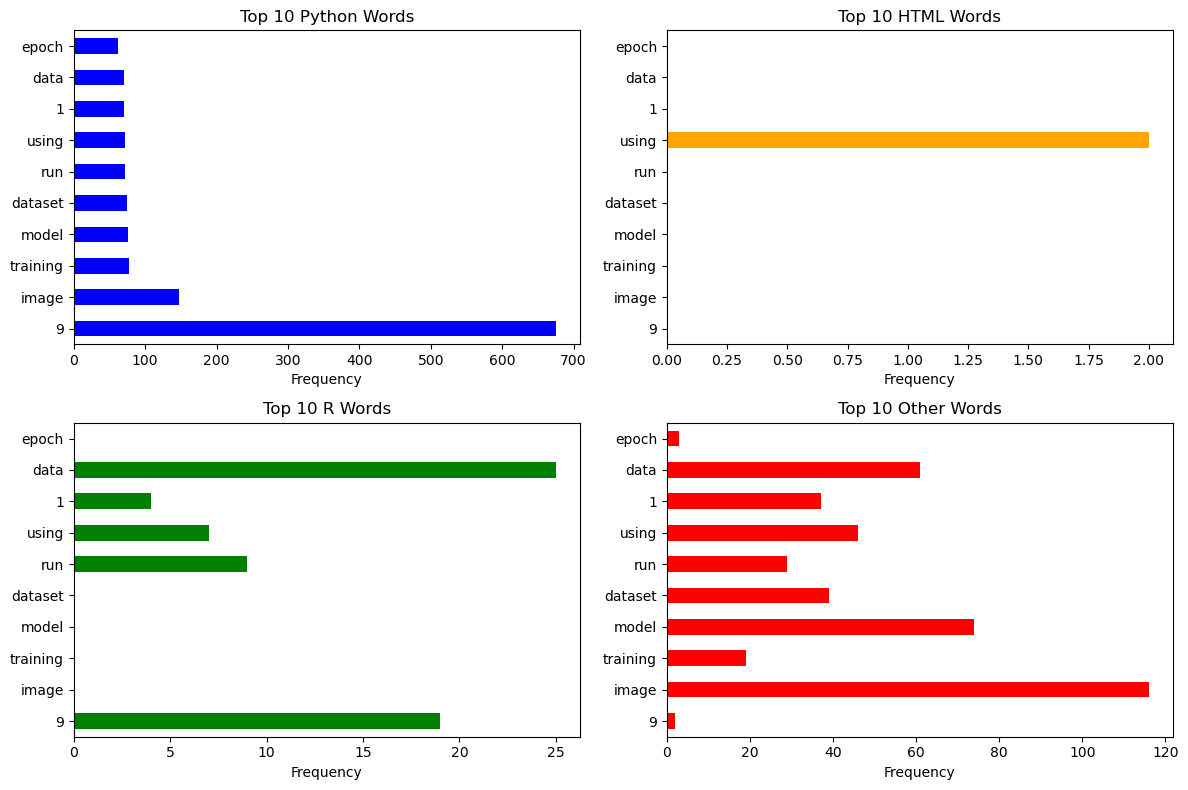

In [46]:
import matplotlib.pyplot as plt

# Assuming 'top_20_words' DataFrame is already defined

# Create a function to find the top N words in descending order for each column
def find_top_n_words(data, n):
    top_words = data.head(n)
    return top_words

# Define the number of top words you want to find
n_top_words = 10

# Find the top 10 words in descending order for each column
top_10_python_words = find_top_n_words(top_20_words['Python'], n_top_words)
top_10_HTML_words = find_top_n_words(top_20_words['HTML'], n_top_words)
top_10_R_words = find_top_n_words(top_20_words['R'], n_top_words)
top_10_Other_words = find_top_n_words(top_20_words['Other'], n_top_words)

# Create a bar chart for the top 10 words in each column
plt.figure(figsize=(12, 8))

# Python
plt.subplot(2, 2, 1)
top_10_python_words.plot(kind='barh', color='blue')
plt.title('Top 10 Python Words')
plt.xlabel('Frequency')

# HTML
plt.subplot(2, 2, 2)
top_10_HTML_words.plot(kind='barh', color='orange')
plt.title('Top 10 HTML Words')
plt.xlabel('Frequency')

# R
plt.subplot(2, 2, 3)
top_10_R_words.plot(kind='barh', color='green')
plt.title('Top 10 R Words')
plt.xlabel('Frequency')

# Other
plt.subplot(2, 2, 4)
top_10_Other_words.plot(kind='barh', color='red')
plt.title('Top 10 Other Words')
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()


# Bigram

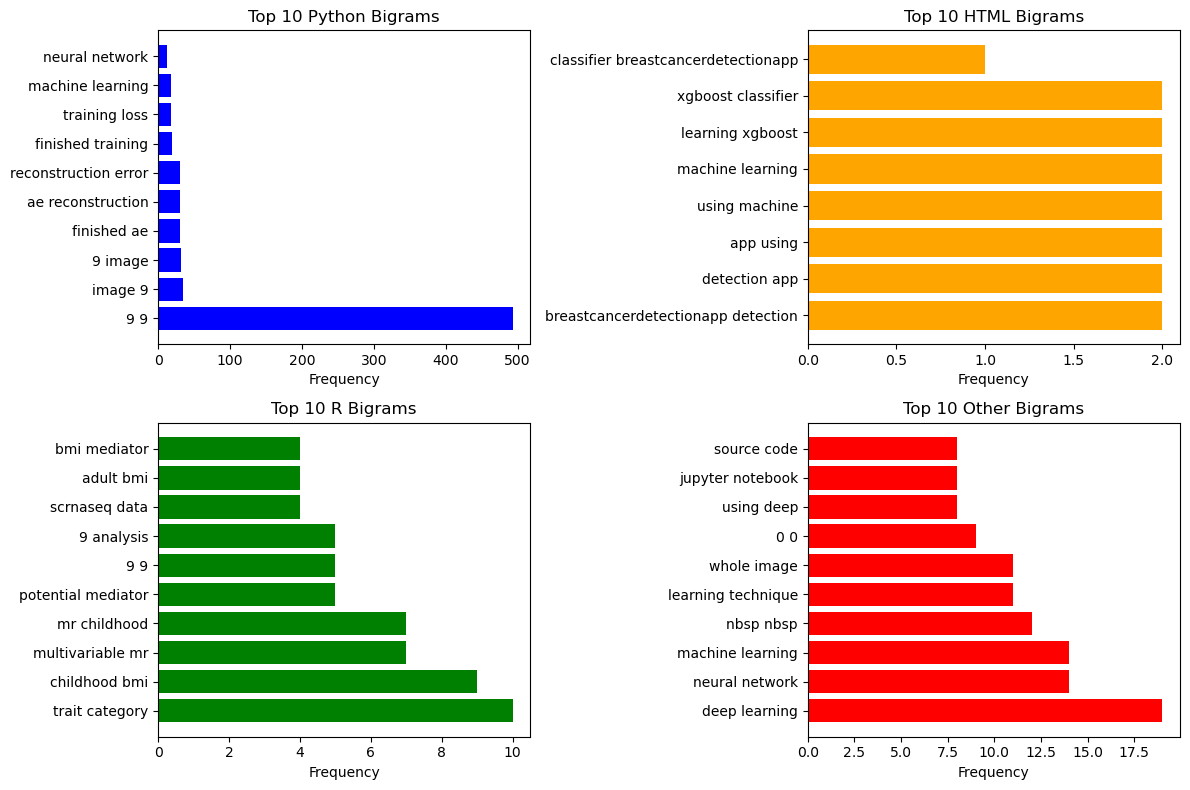

In [51]:
import matplotlib.pyplot as plt
import nltk

# Define a function to find the top N bigrams in descending order for each column
def find_top_n_bigrams(data, n):
    # Tokenize the text data for the column and create bigrams
    bigrams = list(nltk.bigrams(data))
    
    # Calculate the frequency of each bigram
    bigram_freq = nltk.FreqDist(bigrams)
    
    # Find the top N bigrams
    top_bigrams = bigram_freq.most_common(n)
    return top_bigrams

# Define the number of top bigrams you want to find
n_top_bigrams = 10

# Find the top 10 bigrams in descending order for each column
top_10_python_bigrams = find_top_n_bigrams(python_words, n_top_bigrams)
top_10_HTML_bigrams = find_top_n_bigrams(html_words, n_top_bigrams)
top_10_R_bigrams = find_top_n_bigrams(r_words, n_top_bigrams)
top_10_Other_bigrams = find_top_n_bigrams(other_words, n_top_bigrams)

# Create a bar chart for the top 10 bigrams in each column
plt.figure(figsize=(12, 8))

# Python
plt.subplot(2, 2, 1)
top_10_python_bigrams_freq = [bigram[1] for bigram in top_10_python_bigrams]
top_10_python_bigrams_labels = [" ".join(bigram[0]) for bigram in top_10_python_bigrams]
plt.barh(top_10_python_bigrams_labels, top_10_python_bigrams_freq, color='blue')
plt.title('Top 10 Python Bigrams')
plt.xlabel('Frequency')

# HTML
plt.subplot(2, 2, 2)
top_10_HTML_bigrams_freq = [bigram[1] for bigram in top_10_HTML_bigrams]
top_10_HTML_bigrams_labels = [" ".join(bigram[0]) for bigram in top_10_HTML_bigrams]
plt.barh(top_10_HTML_bigrams_labels, top_10_HTML_bigrams_freq, color='orange')
plt.title('Top 10 HTML Bigrams')
plt.xlabel('Frequency')

# R
plt.subplot(2, 2, 3)
top_10_R_bigrams_freq = [bigram[1] for bigram in top_10_R_bigrams]
top_10_R_bigrams_labels = [" ".join(bigram[0]) for bigram in top_10_R_bigrams]
plt.barh(top_10_R_bigrams_labels, top_10_R_bigrams_freq, color='green')
plt.title('Top 10 R Bigrams')
plt.xlabel('Frequency')

# Other
plt.subplot(2, 2, 4)
top_10_Other_bigrams_freq = [bigram[1] for bigram in top_10_Other_bigrams]
top_10_Other_bigrams_labels = [" ".join(bigram[0]) for bigram in top_10_Other_bigrams]
plt.barh(top_10_Other_bigrams_labels, top_10_Other_bigrams_freq, color='red')
plt.title('Top 10 Other Bigrams')
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()


# Hypothesis 1

# Hypothesis 2 

# Hypothesis 3

# Hypothesis 4

# Modeling 

In [17]:
# Assuming 'df' is your DataFrame
df.dropna(subset=['language'], inplace=True)

# Now you can proceed with your train-test split function
train, validate, test = w.split_function_cat_target(df, "language")
